This notebook documents the final DistilBERT model training, validation, and test at the final stage of the model finetuning for the Modelling Racial Caste System Project.

## Packages

* More packages get imported in or right before the chunks that apply them to reduce conflict issues and allow for seamless implementation.

In [1]:
import transformers

print(transformers.__version__)

4.37.2


## Overview

This script used the final training set which had 20,512 sentences, split into 11,312 Virginia sentences and 9,200 North Carolina sentences. The script includes the chechpoints for the second run of the final model which performed worse than than the first version. The first version, saved as "Final_bertmodel1" achieved accuracy: 0.9751 and f1: 0.9368 scores. Instead of reruning the model a 3rd time given the lower performance, we used the first model to run the prediction on the test set. 

The prediction model on the test set prediction achieved accuracy: 0.9936 and f1: 0.9858. This was saved as the final model and used to predict on the entire corpus. The script for the final prediction on the corpus is available in the repository. 

## Data Ingestion

Load Dataset into Pandas Dataframe. The links below contain helpful information on loading datasets for transformer classsification.

https://huggingface.co/docs/datasets/tabular_load#pandas-dataframes  
https://huggingface.co/docs/datasets/loading  
https://huggingface.co/docs/transformers/tasks/sequence_classification

In [3]:
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from fast_ml.model_development import train_valid_test_split

# Load the final training set after the clean and validation. There is no random seed used in the split. 
df = pd.read_csv("fullvncjc_dataframe24_final.csv")
df.drop(columns = 'Unnamed: 0.1', inplace=True)
features = df.loc[:,['year','sentence', 'jim_crow','state']].copy()
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'jim_crow', train_size=0.8, valid_size=0.1, test_size=0.1)

# Organize the data for further processing
train_data = pd.concat([X_train, y_train], axis=1)
valid_data = pd.concat([X_valid, y_valid], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

#Limit to two data points
train = train_data.loc[:,['sentence', 'jim_crow']].copy()
valid = valid_data.loc[:,['sentence', 'jim_crow']].copy()
test = test_data.loc[:,['sentence', 'jim_crow']].copy()

# Renaming columns and Reindex
train = train.set_index('sentence', inplace=False)
valid = valid.set_index('sentence', inplace=False)
test = test.set_index('sentence', inplace=False)

train = train.rename(columns={"jim_crow": "label"})
valid = valid.rename(columns={"jim_crow": "label"})
test = test.rename(columns={"jim_crow": "label"})


In [4]:
# Check the number of Jim Crow "1" and Non-Jim Crow "0" in the test set

test.value_counts(["label"])

label
0        1592
1         460
dtype: int64

In [5]:
# Check the first few sentences in the training set

train.head()

,label
sentence,
"That chapter seven hundred and seventy-five of the Public-Local Laws of one thousand nine hundred and thirteen, entitled An act to prohibit disorderly conduct, prevent public drunkenness, and protect certain churches and associations, be and the same is hereby amended as follows: In section four, line two, after the word highways insert the words, or on any railway train in lime five of said section strike out the word fifteen and insert the word fifty also in line five strike out the word fifty and insert the words one hundred in line six strike out the word five and insert the word thirty also in line six strike out the word thirty and insert the word sixty.",0
"Said deed for said land having been made by Joel F. Trogdon, September , , to the colored people of Franklinville Township for school purposes.",1
"The sanitary district board shall then determine the amount of funds to be raised for the ensuing year in excess of the funds available from surplus operating revenues set aside as provided in section twenty of this act to provide payment of interest and the proportionate part of the principal of all outstanding bonds, and to retire all outstanding certificates of indebtedness.",0
"line thence with Alleys upper outside line to F. H. Leatherwoods line thence with Leatherwoods upper outside line to L. L. Buchanans line thence with Buchanans line to a point above the reservoir of the Webster waterworks thence in an easterly direction, so as to include said reservoir and waterworks, crossing the lands of Tyler Buchanan, Mrs. R. F. McKee and W. D. Frizell to J. W. Terrells line thence with Terrells line to C. W. Davis line thence with the said Davis outside line to the line between the county farm and J. W. Davis thence with J. W. Davis upper line to A. V. P. Brysons line thence a straight line to Tuckaseigee River thence across said river to a stake on the bank of.",0
"No such ordinance or by-law shall be passed until after notice of an intention to propose the same for passage shall have been pub- lished once a week for two successive weeks prior to its passage in some newspaper published in the county, and if there be none such, in some newspaper published in an adjoining county or a nearby city and having a general circulation in the county of said board, and no such ordinance or by-laws shall become effective until after it shall have been published in full once a week for two successive weeks in a like newspaper.",0


## Preprocessing and Analysis Setup

We tokenized and prepared the sentence column for input into the DistilBERT model:

* We utilized the Dataset module to preprocess the split datasets (train, valid, and test) into a format compatible with analysis and model training, ensuring proper designation of training, validation, and testing subsets. 
* The AutoTokenizer from the transformers library, pre-trained for distilbert-base-uncased, was used for tokenization.
* Sentences were tokenized into numerical IDs and attention masks, automatically handling tasks like lowercasing and truncation of sequences longer than the model's maximum length of 512 tokens.
* The tokenization process was applied to the training and testing datasets using the map function, ensuring that the outputs were formatted correctly for the DistilBERT model.
* Dynamic Padding: We used the DataCollatorWithPadding to dynamically pad sequences in each batch to the length of the longest sequence. This ensures efficient batching and compatibility with the TensorFlow framework, without introducing unnecessary computational overhead.

In [6]:
# Use the dataset module to preprocess the split datasets into a valid format for analysis

train_ds = Dataset.from_pandas(train, split="train")
valid_ds = Dataset.from_pandas(valid, split="validation")
test_ds = Dataset.from_pandas(test, split="test")

In [7]:
valid_ds

Dataset({
    features: ['label', 'sentence'],
    num_rows: 2051
})

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [9]:
def preprocess_function(examples):
    return tokenizer(examples["sentence"], truncation=True)

In [10]:
tokenized_train = train_ds.map(preprocess_function, batched=True)
tokenized_valid = valid_ds.map(preprocess_function, batched=True)
tokenized_test = test_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/16409 [00:00<?, ? examples/s]

Map:   0%|          | 0/2051 [00:00<?, ? examples/s]

Map:   0%|          | 0/2052 [00:00<?, ? examples/s]

In [11]:
tokenized_train

Dataset({
    features: ['label', 'sentence', 'input_ids', 'attention_mask'],
    num_rows: 16409
})

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

2024-02-26 21:53:10.890591: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

## Classification Metrics

We designated accuracy and F1 as the primary metrics of interest to evaluate model performance.

To implement this:

#### Metrics Computation:
* A compute_metrics function calculates accuracy and F1 scores by comparing model predictions with true labels.
* Predictions are derived from model logits using np.argmax to identify the most probable class.
#### Label Mapping:
* The id2label and label2id dictionaries map numeric labels (used internally by the model) to descriptive labels ("jim_crow" and "non_jim_crow") for interpretability.
#### Optimizer and Learning Rate Scheduler:
* An Adam-based optimizer is configured with an initial learning rate (init_lr=2e-5) and a warm-up schedule to stabilize training.
* Training setup includes a batch size of 16, 6 epochs, and dynamically calculated total_train_steps.

In [15]:
import numpy as np
import evaluate

def compute_metrics(eval_pred):
    load_accuracy = evaluate.load("accuracy")
    load_f1 = evaluate.load("f1")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy =  load_accuracy.compute(predictions=predictions, references= labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references= labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

In [16]:
id2label = {0: "non_jim_crow", 1: "jim_crow"}
label2id = {"non_jim_crow": 0, "jim_crow": 1}

In [17]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 10
batches_per_epoch = len(tokenized_train) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=5,  # Adjust this based on the size of your dataset
    num_train_steps=total_train_steps,
)

#optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

2024-02-26 21:53:24.352263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78791 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2024-02-26 21:53:24.356055: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78791 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:87:00.0, compute capability: 8.0


## Model Training and Testing

We prepared the model and datasets for training, monitored its performance using metrics, and saved the final model for deployment:

#### Model Initialization:
* The DistilBERT model is loaded with pre-trained weights for text classification.
* The model is configured for binary classification with num_labels=2 and uses the label mappings (id2label and label2id) for consistency.
#### Dataset Preparation:
* Training, validation, and testing datasets were prepared using the prepare_tf_dataset method. This ensured proper batching and padding of tokenized data for compatibility with TensorFlow.
#### Compilation and Training:
* The model was compiled with the Adam-based optimizer.
* Training was performed for 6 epochs with a batch size of 16, and validation metrics were monitored using the KerasMetricCallback for accuracy and F1. Epoch 4 had the highest accuracy and F1 scores.
#### Saving the Model:
* The trained model and tokenizer were saved to \"Final_bertmodel\" and \"Final_bertmodel_tokenizer\", enabling reuse for future predictions or further fine-tuning. 
* In this script, as noted above, this checkpoint is for the second run of this model so it is saved differently. We import and use Final_bertmodel and Final_bertmodel_tokenizer later in the script. 

In [18]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [19]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_train,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_valid,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_test,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)


In [21]:
model.compile(optimizer=optimizer) 

In [22]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)


In [23]:
callbacks = [metric_callback]
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=10, callbacks=callbacks)


Epoch 1/10


2024-02-26 21:53:53.279455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-26 21:53:53.490639: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdec286df70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-26 21:53:53.490678: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-02-26 21:53:53.490683: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-02-26 21:53:53.624815: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-26 21:53:53.864855: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-02-26 21:5

1025/1025 [==============================] - 173s 150ms/step - loss: 0.1628 - val_loss: 0.1254 - accuracy: 0.9556 - f1: 0.8918
Epoch 2/10
1025/1025 [==============================] - 64s 62ms/step - loss: 0.0794 - val_loss: 0.1178 - accuracy: 0.9649 - f1: 0.9149
Epoch 3/10
1025/1025 [==============================] - 58s 56ms/step - loss: 0.0454 - val_loss: 0.1263 - accuracy: 0.9654 - f1: 0.9181
Epoch 4/10
1025/1025 [==============================] - 56s 54ms/step - loss: 0.0270 - val_loss: 0.1343 - accuracy: 0.9678 - f1: 0.9250
Epoch 5/10
1025/1025 [==============================] - 55s 54ms/step - loss: 0.0167 - val_loss: 0.1351 - accuracy: 0.9668 - f1: 0.9227
Epoch 6/10
1025/1025 [==============================] - 53s 52ms/step - loss: 0.0106 - val_loss: 0.1637 - accuracy: 0.9668 - f1: 0.9231
Epoch 7/10
1025/1025 [==============================] - 54s 52ms/step - loss: 0.0071 - val_loss: 0.1817 - accuracy: 0.9659 - f1: 0.9213
Epoch 8/10
1025/1025 [==============================] - 5

In [24]:
#This model performed worse than model 1 so we never used it for prediction but saved it for posterity.

model.save_pretrained("Final_bertmodel2")
tokenizer.save_pretrained("Final_bertmodel_tokenizer2")

('Final_bertmodel_tokenizer2/tokenizer_config.json',
 'Final_bertmodel_tokenizer2/special_tokens_map.json',
 'Final_bertmodel_tokenizer2/vocab.txt',
 'Final_bertmodel_tokenizer2/added_tokens.json',
 'Final_bertmodel_tokenizer2/tokenizer.json')

## Test Set Performance

Although model 2 performed worse, we used it to predict on the test set to preserve its performance and compare it with model 1. 
* The model performed reasonably well on the test dataset. Achieving accuracy: 0.9688 and f1: 0.9296 scores. 
* The notebook had some issues displaying outputs leading to long outputs for the confusion matrix but this did not affect the performance and consequently ignored.

In [25]:
# Evaluate on the test set

model.evaluate(tf_test_set, callbacks=[metric_callback])

129/129 [==============================] - 2s 18ms/step - loss: 0.1869


0.18694421648979187

In [28]:
# Running Prediction on the test set
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs = []

for x, y in tf_test_set:
    model_output = model.predict(x)
    logits = model_output.logits
    y_pred_probs.append(logits)

# Combine the predictions into a single array
y_pred_probs = np.concatenate(y_pred_probs, axis=0)

# Convert logits to predictions (0 or 1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluate with your metric function
metrics = compute_metrics((y_pred_probs, np.array(tokenized_test["label"])))

# Display or save the confusion matrix and other metrics
print("Confusion Matrix:")
print(confusion_matrix(np.array(tokenized_test["label"]), y_pred))
print("\nClassification Report:")
print(classification_report(np.array(tokenized_test["label"]), y_pred))
print("\nCustom Metrics:")
print(metrics)

1/1 [==============================] - 0s 31ms/step
Confusion Matrix:
[[1565   27]
 [  37  423]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1592
           1       0.94      0.92      0.93       460

    accuracy                           0.97      2052
   macro avg       0.96      0.95      0.95      2052
weighted avg       0.97      0.97      0.97      2052


Custom Metrics:
{'accuracy': 0.9688109161793372, 'f1': 0.9296703296703296}


## Test Set Performance with Model 1

As explained above, because model 2 had a poor performance, we used model 1 on the test dataset to evaluate the model and compare it to model 2.

We preprocess the test dataset again using the saved model weights and tokenizer instead of the DistilBERT weights and tokenizer as above.

* The model performed exceptionally well on the test dataset. Achieving accuracy: 0.9936 and f1: 0.9858 scores. 

In [31]:
# Load the saved model and tokenizer from model 1

model1 = TFAutoModelForSequenceClassification.from_pretrained("Final_bertmodel1")
tokenizer1 = AutoTokenizer.from_pretrained("Final_bertmodel_tokenizer1")

Some layers from the model checkpoint at Final_bertmodel1 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at Final_bertmodel1 and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
# We preprocess the test dataset again using the saved model weights.

def preprocess_function(examples):
    return tokenizer1(examples["sentence"], truncation=True)

tokenized_test1 = test_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/2052 [00:00<?, ? examples/s]

In [38]:
data_collator1 = DataCollatorWithPadding(tokenizer=tokenizer1, return_tensors="tf")

In [41]:
tf_test_set1 = model1.prepare_tf_dataset(
    tokenized_test1,
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator1,
)


In [45]:
model1.compile(optimizer=optimizer) 

In [46]:
model1.evaluate(tf_test_set1, callbacks=[metric_callback])

129/129 [==============================] - 3s 19ms/step - loss: 0.0397


0.039716705679893494

In [49]:
# Predictions for the test set with model 1
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs1 = []

for x, y in tf_test_set1:
    model_output1 = model1.predict(x)
    logits1 = model_output1.logits
    y_pred_probs1.append(logits1)

# Combine the predictions into a single array
y_pred_probs1 = np.concatenate(y_pred_probs1, axis=0)

# Convert logits to predictions (0 or 1)
y_pred1 = np.argmax(y_pred_probs1, axis=1)

# Evaluate with your metric function
metrics1 = compute_metrics((y_pred_probs1, np.array(tokenized_test1["label"])))

# Display or save the confusion matrix and other metrics
print("Confusion Matrix:")
print(confusion_matrix(np.array(tokenized_test1["label"]), y_pred1))
print("\nClassification Report:")
print(classification_report(np.array(tokenized_test1["label"]), y_pred1))
print("\nCustom Metrics:")
print(metrics)

1/1 [==============================] - 0s 31ms/step
Confusion Matrix:
[[1587    5]
 [   8  452]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1592
           1       0.99      0.98      0.99       460

    accuracy                           0.99      2052
   macro avg       0.99      0.99      0.99      2052
weighted avg       0.99      0.99      0.99      2052


Custom Metrics:
{'accuracy': 0.9936647173489279, 'f1': 0.9858233369683751}


## Performance Visualization

Below we visualize the confusion matrix. The bottom values of the matrix are missing from the visualization due to a jupyter notebook error that requires a lower version of matplotlib than we had installed.

* Running the following code "pip install matplotlib==3.7.1" will downgrade matplotlib and allow you to visualize the complete matrix. 
#### Saving the Model:
* The final trained model and tokenizer were saved to \"UVAJC_Final_bertmodel\" and \"UVAJC_Final_bertmodel_tokenizer\", enabling reuse for prediction on the full corpus. 
* This is the official fianl mosel for the project. 

Confusion Matrix:
[[1587    5]
 [   8  452]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1592
           1       0.99      0.98      0.99       460

    accuracy                           0.99      2052
   macro avg       0.99      0.99      0.99      2052
weighted avg       0.99      0.99      0.99      2052



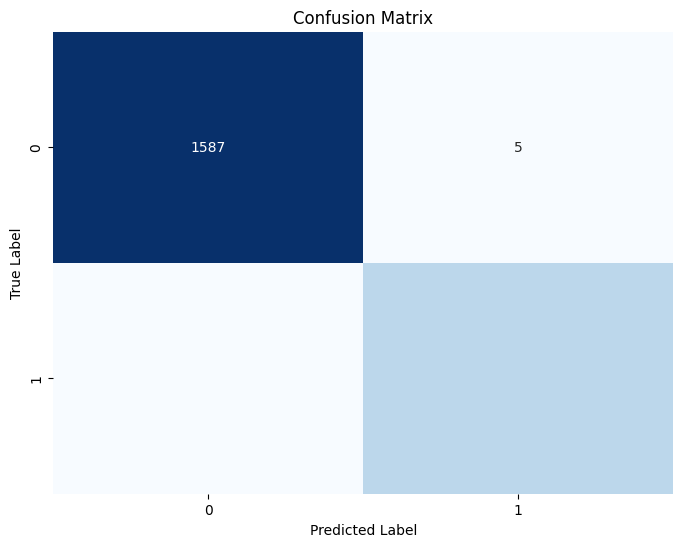

In [51]:
y_true = np.array(tokenized_test1["label"])


# Display or save the confusion matrix and other metrics
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred1))
print("\nClassification Report:")
print(classification_report(y_true, y_pred1))

# Create a DataFrame from the confusion matrix for better visualization
df_cm = pd.DataFrame(confusion_matrix(y_true, y_pred1), index=np.unique(y_true), columns=np.unique(y_true))

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Customize the plot (optional)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [65]:
# We saved the test dataset predictions to a csv file incase we wanted to manually review it.
y_true = np.array(tokenized_test1["label"])

# Create a DataFrame with sentence, true label, and predicted label
df_results = pd.DataFrame({
    'sentence': tokenized_test1["sentence"],
    'true_label': y_true,
    'predicted_label': y_pred1
})

# Save the DataFrame to a CSV file
df_results.to_csv('trainingtest_predictions.csv', index=False)


In [52]:
model2.save_pretrained("UVAJC_Final_bertmodel")
tokenizer2.save_pretrained("UVAJC_Final_bertmodel_tokenizer")

('UVAJC_Final_bertmodel_tokenizer/tokenizer_config.json',
 'UVAJC_Final_bertmodel_tokenizer/special_tokens_map.json',
 'UVAJC_Final_bertmodel_tokenizer/vocab.txt',
 'UVAJC_Final_bertmodel_tokenizer/added_tokens.json',
 'UVAJC_Final_bertmodel_tokenizer/tokenizer.json')

## Prediction on 5000 sentences randomly pulled from the corpus.

The model predicted 348 Jim Crow sentences. 
* Upon manual review of the predictions, the model was .99% accurate, matching the confusion matrix result. 

In [55]:
from transformers import pipeline

# Load the CSV file into a DataFrame
df = pd.read_csv('testset_5k24cleaned.csv')
df = df.loc[:,['sentence', 'jim_crow']].copy()
df = df.rename(columns={"jim_crow": "label"})

# Initialize the trained UVA model and tokenizer inference pipeline for text classification
nlp = pipeline("sentiment-analysis", model="UVAJC_Final_bertmodel", tokenizer="UVAJC_Final_bertmodel_tokenizer", truncation=True)

# Define the name of the text column in your CSV
text_column = 'sentence'  

# Perform inference and add the inferred labels to a new column
df['inferred_label'] = df[text_column].apply(lambda x: nlp(x)[0]['label'])

# Save the updated DataFrame to a new CSV file
df.to_csv('finaltestreview_5k.csv', index=True)

print("Inference results saved to 'finaltestreview_5k.csv'")


Some layers from the model checkpoint at UVAJC_Final_bertmodel were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at UVAJC_Final_bertmodel and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Inference results saved to 'finaltestreview_5k.csv'


In [56]:
df['jim_crow'] = df['inferred_label'].apply(lambda x: 1 if x == 'jim_crow' else 0)
df.to_csv('finaltestreview_5k.csv', index=False)

In [57]:
df.value_counts(["jim_crow"])

jim_crow
0           4652
1            348
dtype: int64

Below we review 50 of the sentences predicted Jim Crow and Non-Jim Crow to review them for quick insights on the prediction accuracy

In [58]:
pd.set_option('display.max_colwidth', None)
df.loc[df.jim_crow != 0, ["sentence","jim_crow","inferred_label"]].sample(50)

,sentence,jim_crow,inferred_label
486,"The term of office of said colored visitors sball be for six years: pro- vided that of the present board, two members shall be desig- nated by the board of education to continue in office until the first day of April, eighteen hundred and cighty-eight, two until the first day of April, eighteen hundred and ninety, and two until the first day of April, eighteen hundred and ninety-two.",1,jim_crow
4832,"1, Be it enacted by the general assembly of Virginia, That the salary and compensation of the county superintendent of schools of Albemarle county shall be as provided by law, except that for the additional and extra duties imposed upon him on account of the Dawson school fund in said county, he shall be entitled to receive such additional and further compensation and salary as the county school board of said county may from time to time allow and order to be paid, the same to be payable out of such funds as said board may direct.",1,jim_crow
4743,The town council may make appropriations of public funds to any public free school of the county of Nottoway which is used or attended by the children of the residents of the town located within the town.,1,jim_crow
2914,~The determination of any two of the freeholders shall be sufficient.,1,jim_crow
2022,"If the owner or tenant of the freehold be unknown or a nonresident of the state or cannot with reasonable diligence be found in the state, or if the residence of the owner or tenant be unknown, he may be proceeded against by order of publication which order, however, need not be published more than once a week for two successive weeks and shall be posted at a main entrance to the courthouse.",1,jim_crow
4864,"or appointed to any office in said town or before the day on which he is to enter _ of his office, or shall, for twenty days f office, fail to give such bond with such im by the council of said town, he shall said office, and the same shall be deemed filled as prescribed in this act or by the - been an officer of said town, shall not ve vacated or been removed from office, f the council within such time as it may office all property, books and papers be- ling to such office, in his possession or and pay to the town a sum not exceeding r and recovered with costs; and all books, y office by virtue of any provision of this er of the town council, or any superior 1ed the property of said town and apper- f officer thereof shall be held responsible cted by the qualified electors of the town alary shall be fixed by the town council, xy his term of office.",1,jim_crow
1361,"Joseph’s Academy and Orphan Asylum, of rachmond, A a $ 6,600 00 $ 330 0 1 lieu of — oo Ten-forty coupon bonds (5 per cent)............ $ 5,000 00 $ 25:00 Ten-forty COUPONS ............ 0c ccc c ee eee eens 1,600 00 80 00 $ 6,600 00 $ 3300 PAUL’S ENDOWMENT FUND.",1,jim_crow
1415,"(Signed) ............ 0. eee e eee Subscribed and sworn to before me, this.............. day of oii ors Qe aw oreo Sr nineteen hundred and...................-- (Signed) ......... 2... ee ee eee eee If any person shall knowingly and wilfully sign such a petition without being legally qualified to do so, or if any person circu- lating such a petition shall, knowingly and wilfully make a false certificate and affidavit to the same, he shall be guilty of a mis- demeanor, and upon conviction shall be fined not less than five nor more than fifty dollars.",1,jim_crow
2669,"A separate ballot-box shall be provided at each voting precinct, in which shall be deposited the ballots of the then qualified voters who shall desire to vote on the question of the said change of location.",1,jim_crow
4613,"For the fiscal year.ending the twenty-eighth day of February nineteen hundred and twelve, and annually thereafter, the sum of thirty thousand dollars is hereby appropriated out of the sum turned over tc the State board of education for apportionment among the schools ot the primary and grammar grades for the purpose of car

In [59]:
df.loc[df.jim_crow != 1, ["sentence","jim_crow","inferred_label"]].sample(50)

,sentence,jim_crow,inferred_label
869,The several county and city treasurers shall be held accountable under their official bonds for all such stamps so furnished them in the same manner as they-are now held accountable for state moneys or other property coming into their hands.,0,non_jim_crow
2812,"CHARLOTTE— Madison, Walton, Bacon, Roanoke, | CHESTERFIELD—Dale, Clover Hill, Midlothian, M muda.",0,non_jim_crow
4767,"® Passed March 2, 1967.",0,non_jim_crow
382,"The said commission shall, from time to time.",0,non_jim_crow
2886,The said company shall commence the construction of the said railroad within one year and complete the same within three years from the passage of this act.,0,non_jim_crow
3811,"It shall be unlawful for any person to grind malt in this State or any substitute for the same by whatever name it may be called, to be used in the manufacture of ardent spirits, and the burden of proof shall be upon any person grinding malt to show that such malt is not to be used in violation of this act, provided that this provision shall not apply to any manufacturer of pure grain or ethy] alcohol licensed to manufacture such alco- hol under this act.",0,non_jim_crow
224,"Be it further enacted that all action heretofore taken and all things done or attempted to be done by said board for the carrying out and accomplishment of the purposes aforesaid, be, and they are hereby authorized, ratified and confirmed.",0,non_jim_crow
1492,"[H B 205] Approved March 14, 1936 1.",0,non_jim_crow
708,"Any vessel in which oysters are taken contrary to this sec- tion, shall be forfeited and sold, one-half of the proceeds to go to the state, when convicted, ‘and the other half to the in- former.",0,non_jim_crow
2194,Any license tax hereunder shall be in addition to any license tax imposed by the State or any town in such county.,0,non_jim_crow
